In [1]:
from orphics import sehgal, maps
import healpy as hp
from pixell import utils, enmap, curvedsky, enplot, wcsutils, powspec
import os
import numpy as np

import matplotlib.pyplot as plt
import lmdb
from cosmikyu import datasets, transforms, gan, sehgal
from cosmikyu import nn as cnn
from scipy.ndimage.filters import gaussian_filter1d

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:

shape, wcs = enmap.fullsky_geometry(res=0.5*utils.arcmin)
ycent = shape[0] // 2
ydelta = int(10*utils.degree/(0.5*utils.arcmin))
ymin, ymax = ycent-ydelta, ycent+ydelta
print(shape, ycent, ydelta, ymin, ymax)

stamp_width = 128
template = enmap.zeros(shape, wcs)
template = template[ymin:ymax,:].copy()
nshape, nwcs = template.shape, template.wcs
ntiles = np.array(nshape)//stamp_width
print(ntiles)

input_dir = "/home/dwhan89/scratch/data/sehgal_et_al_sims/cosmo_sim_maps/July2009/output/131020_hybrid_projection"
S10R = sehgal.Sehgal10Reprojected(input_dir, shape, wcs)

/home/dwhan89/.miniconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(21601, 43200) 10800 1200 9600 12000
[ 18 337]


/home/dwhan89/.miniconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/home/dwhan89/.miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in true_divide


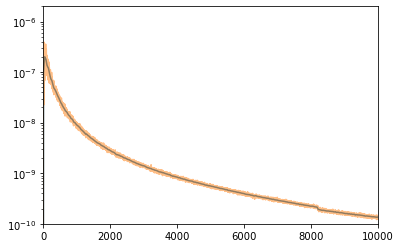

/home/dwhan89/.miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide


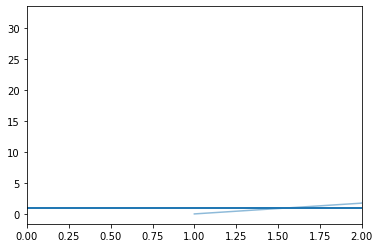

In [4]:
lmax = 10000
ps_scalar = powspec.read_camb_scalar("/home/dwhan89/scratch/data/sehgal_et_al_sims/theoryCls/bode_almost_wmap5_lmax_1e4_scalCls.dat")
clpp = ps_scalar[1][0][0][:lmax+1]
L = np.arange(lmax+1)
clkk = clpp*(L*(L+1))**2/4

beam_fwhm = 0.9
beam_fwhm = np.deg2rad(beam_fwhm/60.)
sigma     = beam_fwhm/(2.*np.sqrt(2.*np.log(2)))
def get_f_ell(l):
    f_ell = np.exp(-(l)**2.*sigma**2./2)
    return l, f_ell

nsample = 200*1000
overwrite = True

sim_specs = S10R.get_specs()
L_sim = sim_specs["l"]
clkk_sim = sim_specs["dls_kappaxkappa"]/(L_sim*L_sim+1)*np.pi*2

transf = gaussian_filter1d(clkk_sim[:], sigma=10)/clkk
transf_corr = np.nan_to_num(transf, nan=1)
transf_corr[:2] = 1.

plt.plot(L,clkk*transf_corr)
plt.plot(L_sim, clkk_sim, alpha=0.5)
plt.xlim(0,10000)
plt.ylim(1e-10,2e-6)
plt.yscale("log")
plt.show()

plt.plot(L_sim[:], clkk[:]*transf_corr/clkk_sim[:], alpha=0.5)
plt.axhline(0.98)
plt.axhline(1.02)
plt.axhline(1)
plt.xlim(0,2)
#plt.ylim(0.8,2)
plt.yscale("linear")
plt.show()





In [5]:
stamp_byte = np.zeros((1, stamp_width, stamp_width), dtype=np.float).nbytes
output_dir = "/home/dwhan89/workspace/cosmikyu/data/sehgal"
def output_path(x):
    return os.path.join(output_dir, x)

kappa_db = output_path("sehgal_Gkappa281220")
if not os.path.exists(kappa_db) or overwrite:
    map_size = stamp_byte*nsample*10
    DB = lmdb.open(kappa_db, map_size=map_size)
    ctr = 0
    while(ctr < nsample):
        alm = curvedsky.rand_alm(clkk*transf_corr)
        #alm = hp.almxfl(alm, get_f_ell(L)[1])
        kmap = curvedsky.alm2map(alm, template)
        kmap = kmap[np.newaxis,...]
        with DB.begin(write=True) as txn:
            for i in range(ntiles[0]):
                ysidx, yeidx = i*stamp_width, (i+1)*stamp_width
                for j in range(ntiles[1]):
                    if ctr % (1000*5) == 0: print(ctr)
                    str_idx = '{:08}'.format(ctr)
                    xsidx, xeidx = j*stamp_width, (j+1)*stamp_width
                    stamp = kmap[:1, ysidx:yeidx, xsidx: xeidx].copy()
                    txn.put(str_idx.encode('ascii'), stamp.tobytes())
                    ctr += 1

        del kmap

/home/dwhan89/.miniconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0
5000
10000
15000
20000
25000
30000
35000
40000
45000
50000
55000
60000
65000
70000
75000
125000
130000
135000
140000
145000
150000
155000
160000
165000
170000
175000
180000
185000
190000
195000
200000


In [7]:
storage = np.zeros((len(L),2))
storage[:,0] = L
storage[:,1] = clkk*transf_corr

np.save(spec_file, storage)



/home/dwhan89/.miniconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0.2836664337170864


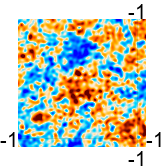

0.22286220412776148


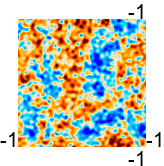

0.2939355687894537


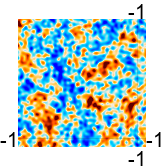

0.22659448627424122


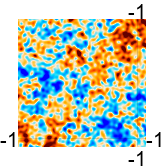

0.22850021354197544


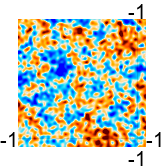

In [4]:
norm_info_file = "/home/dwhan89/workspace/cosmikyu/data/sehgal/201020_logzshrink_normalization_info_validation.npz"
compts = ["kappa"]
SDN = transforms.SehgalDataNormalizerScaledLogZShrink(norm_info_file, channel_idxes=compts)
SUN = transforms.SehgalDataUnnormalizerScaledLogZShrink(norm_info_file, channel_idxes=compts)

DB = datasets.SehgalDataSet(output_dir, "Gkappa191120", transforms=[SDN], shape=(1,stamp_width,stamp_width))
nplot = 1
_, wcs = maps.rect_geometry(width_arcmin=128., px_res_arcmin=0.5)
for j in range(5):
    print(np.max(SUN(DB[j].copy())))
    enplot.pshow(enmap.enmap(SUN(DB[j].copy()), wcs))
